# Model Deployment

## Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

## Load Dataset

Data Penempatan mahasiswa di kampus XYZ. Termasuk data nilai / score untuk:

1. sekolah menengah (SMP) : ssc
2. sekolah menengah atas (SMA) dan spesialisasi (Kejuruan) : hsc
3. spesialisasi gelar (S1) : degree, mba
4. jenis dan pengalaman kerja : workex, etest
5. tawaran gaji kepada siswa yang ditempatkan : salary

In [3]:
data = pd.read_csv('Placement_Data_Full_Class.csv')
display(data.head())

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


- Kita memiliki data kualifikasi Gender dan Pendidikan
- Kita memiliki data performa / score pendidikan
- Kita memiliki data status penempatan dan salary
- Variabel status (penempatan) adalah target output kita (y). Variabel ini independent terhadap semua variabel, kecuali pada variabel salary.

In [4]:
data.tail()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
210,211,M,80.6,Others,82.0,Others,Commerce,77.6,Comm&Mgmt,No,91.0,Mkt&Fin,74.49,Placed,400000.0
211,212,M,58.0,Others,60.0,Others,Science,72.0,Sci&Tech,No,74.0,Mkt&Fin,53.62,Placed,275000.0
212,213,M,67.0,Others,67.0,Others,Commerce,73.0,Comm&Mgmt,Yes,59.0,Mkt&Fin,69.72,Placed,295000.0
213,214,F,74.0,Others,66.0,Others,Commerce,58.0,Comm&Mgmt,No,70.0,Mkt&HR,60.23,Placed,204000.0
214,215,M,62.0,Central,58.0,Others,Science,53.0,Comm&Mgmt,No,89.0,Mkt&HR,60.22,Not Placed,NaN


In [5]:
display(data.info())
print('Data shape (row, column): {}'.format(data.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


None

Data shape (row, column): (215, 15)


- Kolom sl_no terlihat berfungsi hanya sebagai index, maka kita akan drop kolom tersebut.
- Dapat dilihat terdapat missing values pada kolom salary

In [6]:
data.drop(columns=['sl_no'], inplace=True)

Untuk memudahkan analisis data, kita akan menggunakan library pandas_profiling untuk mengenali kondisi data.<br>
Mengingat tujuan kita pada sesi 15 ini adalah untuk deploy model yang kita buat.

## Pandas Profiling

In [7]:
report_pp = data.profile_report(progress_bar=False, title='Campus Placement Data - Report')

# saving the report
report_pp.to_file(output_file='Campus Placement Data - Report.html')
report_pp

Berdasarkan report yang kita generate menggunakan library pandas_profiling, berikut ini beberapa informasi yang kita peroleh:
- Terdapat missing values pada variabel salary, yaitu sebanyak 67 objek (31.2%), kita perlu mengisi missing values tersebut
- Sebagai mana telah kita pelajari skewness = 0 menunjukkan data yg simetris sempurna. Kolom salary memiliki nilai skewness = 3.56 (positive skew), yang artinya right tail lebih panjang. Kita akan scaling variable ini agar mendapatkan hasil yang lebih simetris.
- Rentang nilai pada kolom salary berada di 200K - 940K, terdapat beberapa data outlier melihat Q3 = 300K
- Kolom numeric lainnya sepertinya merupakan score karena rentang nilainya tidak melebihi angka 100

## Data Cleaning

Cleaning yang perlu kita lakukan hanya handling missing values pada kolom salary.

In [8]:
data[data['salary'].isna()]

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
3,M,56.0,Central,52.0,Central,Science,52.00,Sci&Tech,No,66.00,Mkt&HR,59.43,Not Placed,NaN
5,M,55.0,Others,49.8,Others,Science,67.25,Sci&Tech,Yes,55.00,Mkt&Fin,51.58,Not Placed,NaN
6,F,46.0,Others,49.2,Others,Commerce,79.00,Comm&Mgmt,No,74.28,Mkt&Fin,53.29,Not Placed,NaN
9,M,58.0,Central,70.0,Central,Commerce,61.00,Comm&Mgmt,No,54.00,Mkt&Fin,52.21,Not Placed,NaN
12,F,47.0,Central,55.0,Others,Science,65.00,Comm&Mgmt,No,62.00,Mkt&HR,65.04,Not Placed,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,F,67.0,Central,70.0,Central,Commerce,65.00,Others,No,88.00,Mkt&HR,71.96,Not Placed,NaN
201,M,54.2,Central,63.0,Others,Science,58.00,Comm&Mgmt,No,79.00,Mkt&HR,58.44,Not Placed,NaN
206,M,41.0,Central,42.0,Central,Science,60.00,Comm&Mgmt,No,97.00,Mkt&Fin,53.39,Not Placed,NaN
208,F,43.0,Central,60.0,Others,Science,65.00,Comm&Mgmt,No,92.66,Mkt&HR,62.92,Not Placed,NaN


Jika kita perhatikan, missing values pada kolom salary memiliki nilai status = "Not Placed". Mungkin artinya memang belum terdata.

In [10]:
data[(data['status'] == 'Not Placed') & ~(data['salary'].isna())]

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary


Setelah kita cek, ternyata memang benar data salary belum ada untuk status "Not Placed", sehingga kita dapat handling missing values dengan menganggap nilai salary = 0

In [11]:
data['salary'].fillna(0, inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          215 non-null    object 
 1   ssc_p           215 non-null    float64
 2   ssc_b           215 non-null    object 
 3   hsc_p           215 non-null    float64
 4   hsc_b           215 non-null    object 
 5   hsc_s           215 non-null    object 
 6   degree_p        215 non-null    float64
 7   degree_t        215 non-null    object 
 8   workex          215 non-null    object 
 9   etest_p         215 non-null    float64
 10  specialisation  215 non-null    object 
 11  mba_p           215 non-null    float64
 12  status          215 non-null    object 
 13  salary          215 non-null    float64
dtypes: float64(6), object(8)
memory usage: 23.6+ KB


Missing values telah teratasi.

## Exploring Data

#### Distribution

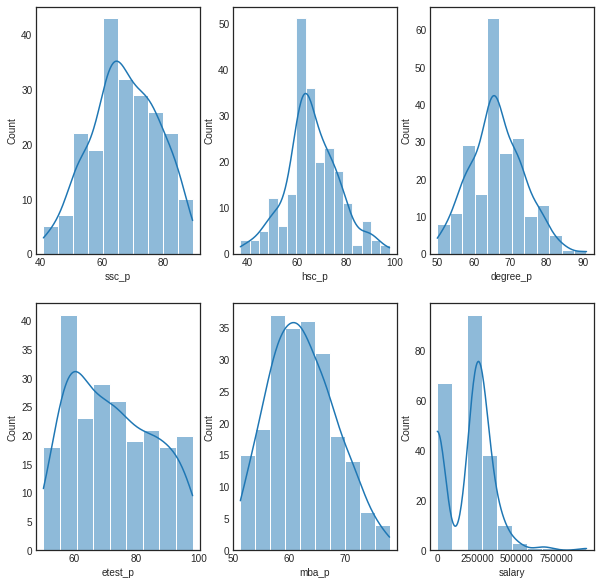

In [13]:
plt.figure(figsize = (15, 7))
plt.style.use('seaborn-white')
plt.subplot(231)
sns.histplot(data['ssc_p'], kde=True)
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(232)
sns.histplot(data['hsc_p'], kde=True)
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(233)
sns.histplot(data['degree_p'], kde=True)
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(234)
sns.histplot(data['etest_p'], kde=True)
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(235)
sns.histplot(data['mba_p'], kde=True)
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(236)
sns.histplot(data['salary'], kde=True)
fig = plt.gcf()
fig.set_size_inches(10,10)
fig

- Semua feature berdistribusi normal kecuali feature salary
- Pada setiap jenjang pendidikan, score / point paling banyak berada pada rentang 60-80
- Terdapat outlier pada feature salary dimana hanya sedikit yang ditawarkan salary > 500K

### Gender

Apakah gender mempengaruhi status penempatan?

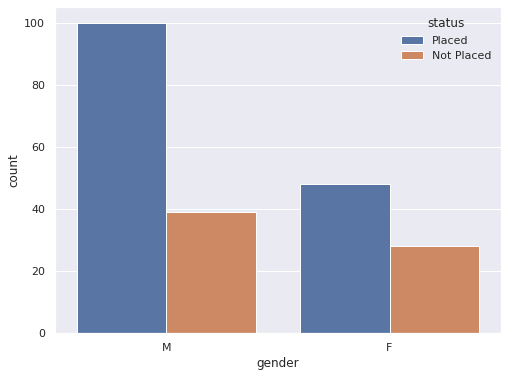

In [14]:
%matplotlib inline
sns.set(rc={"figure.figsize":(8,6)})
sns.countplot(x="gender", hue="status", data=data)
plt.show()

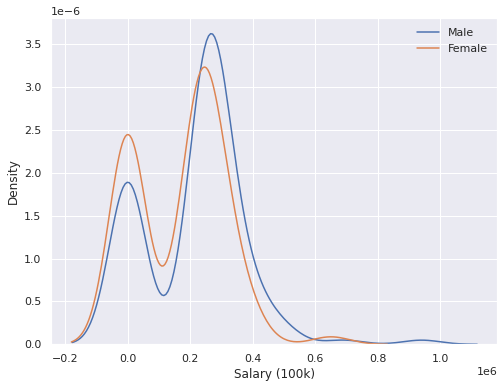

In [15]:
sns.kdeplot(data.salary[data.gender=="M"])
sns.kdeplot(data.salary[data.gender=="F"])
plt.legend(["Male", "Female"])
plt.xlabel("Salary (100k)")
plt.show()

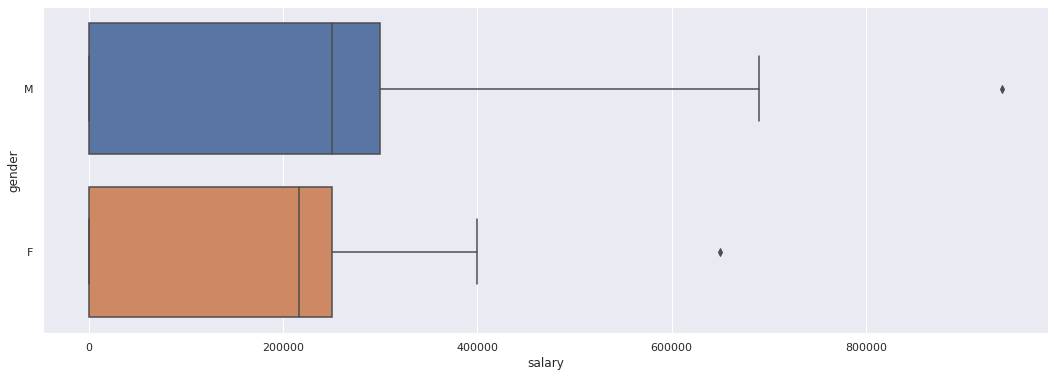

In [16]:
plt.figure(figsize =(18,6))
sns.boxplot(x="salary", y="gender", data=data)
plt.show()

<strong><em>Insight:</em></strong>
- Kita memiliki data 139 male dan 76 female
- Sebanyak 30 female dan 40 male belum mendapatkan penempatan (status="Not Placed").
- 71.22 % male dan 60.52 % female telah mendapatkan penempatan. Male cenderung memiliki penempatan lebih besar daripada perempuan.
- Rata-rata tawaran salary untuk male lebih besar daripada female.

#### High School Education Percentage (hsc_p) & Board of High School Education (hsc_b)
Apakah Sekolah Menengah Atas (SMA) mempengaruhi status penempatan?

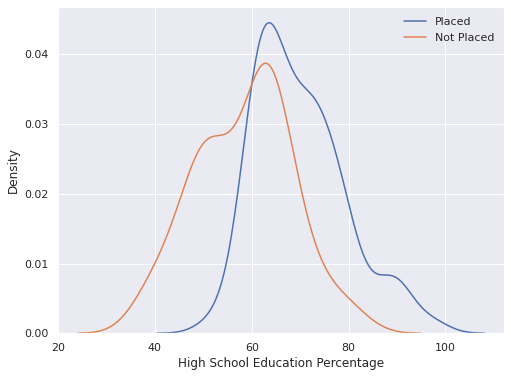

In [18]:
sns.kdeplot(data[data['status'] == "Placed"]['hsc_p'])
sns.kdeplot(data[data['status'] == "Not Placed"]['hsc_p'])
plt.legend(["Placed", "Not Placed"])
plt.xlabel("High School Education Percentage")
plt.show()

- Siswa dengan score persentase lebih dari 90 telah memperoleh penempatan
- Siswa dengan score persentase kurang dari 40 belum memperoleh penempatan
- Rata-rata siswa yang memiliki score persentase yang baik (60-80) telah memperoleh penempatan

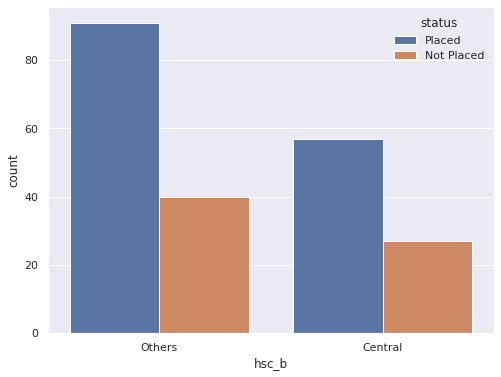

In [19]:
sns.countplot(x="hsc_b", hue="status", data=data)
plt.show()

In [20]:
data.groupby(['hsc_b', 'status']).count()['gender']

hsc_b    status    
Central  Not Placed    27
         Placed        57
Others   Not Placed    40
         Placed        91
Name: gender, dtype: int64

- Board of High School Education tidak banyak mempengaruhi status penempatan.
- Others = 91/131 = 69.46%
- Central = 57/84 = 67.85%

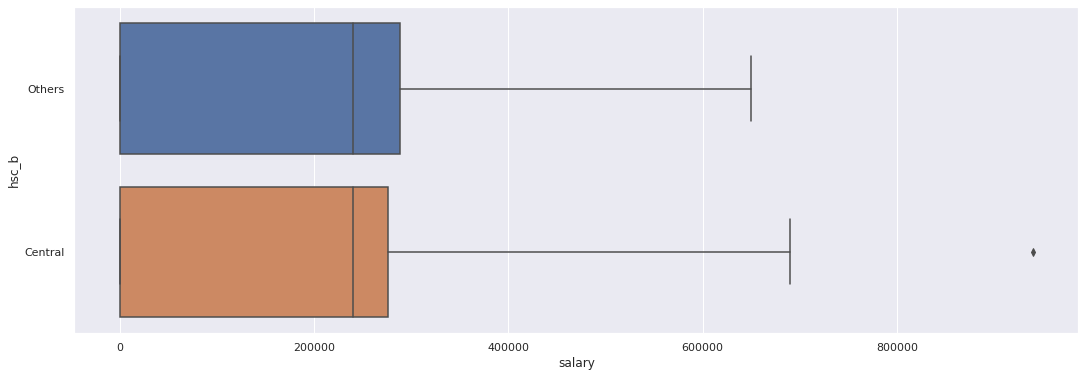

In [21]:
plt.figure(figsize =(18,6))
sns.boxplot(x="salary", y="hsc_b", data=data)
plt.show()

Outliers terdapat pada keduanya, tetapi siswa dari Central Board mendapatkan tawaran salary lebih tinggi.

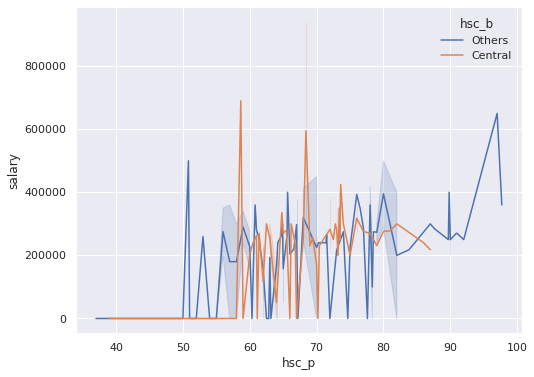

In [22]:
sns.lineplot(x="hsc_p", y="salary", hue="hsc_b", data=data)
plt.show()

Tidak ada pola khusus (correlation) antara High School Education Percentage dan Salary. Board of Education Tidak Mempengaruhi Gaji

#### Working Experience
Apakah pengalaman kerja mempengaruhi status penempatan?

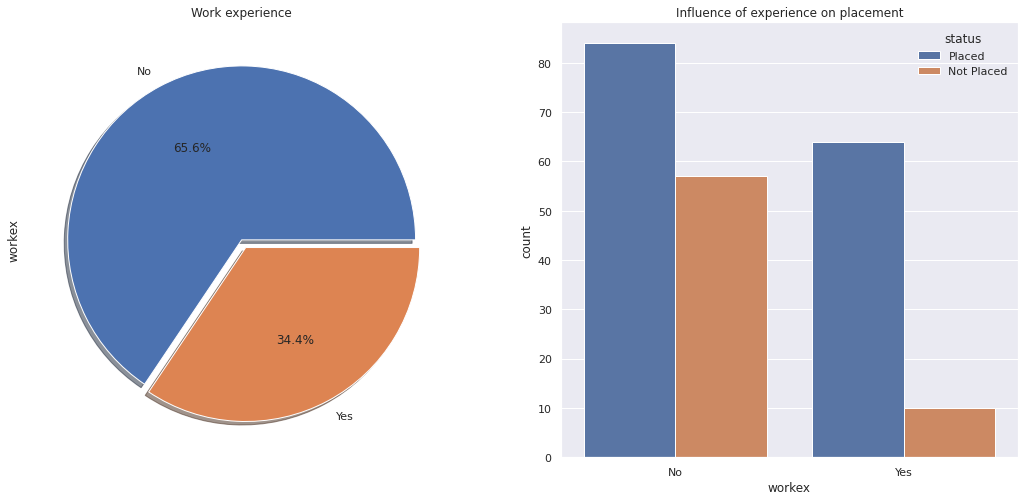

In [23]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data['workex'].value_counts().plot.pie(explode=[0,0.05], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Work experience')
sns.countplot(x = 'workex',hue = "status",data = data)
ax[1].set_title('Influence of experience on placement')

plt.show()

- 65.6% siswa tidak memiliki working experience
- Siswa yang tidak memiliki working experience cenderung mendapatkan penempatan daripada yang memiliki working experience.
- Kita dapat menyimpulkan bahwa working experience tidak begitu mempengaruhi status penempatan

### Data Pre-processing

In [24]:
# Convert data categorical to numeric
object_cols = ['gender','workex','specialisation','status']

label_encoder = LabelEncoder()
for col in object_cols:
    data[col] = label_encoder.fit_transform(data[col])
data.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,0,55.0,1,58.80,1,270000.0
1,1,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,1,86.5,0,66.28,1,200000.0
2,1,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,0,75.0,0,57.80,1,250000.0
3,1,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,0,66.0,1,59.43,0,0.0
4,1,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,0,96.8,0,55.50,1,425000.0


In [25]:
# Seperating Features and Target
X = data[['ssc_p', 'hsc_p', 'degree_p', 'etest_p']]
y = data['status']

In [26]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

### Classification Method

##### Decision Tree

In [28]:
# Decision Tree
dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)

print("Accuracy Score : {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test, y_pred))

Accuracy Score : 83.08%
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        20
           1       0.85      0.91      0.88        45

    accuracy                           0.83        65
   macro avg       0.81      0.78      0.79        65
weighted avg       0.83      0.83      0.83        65



##### Random Forest

In [29]:
# Using Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

print("Accuracy Score : {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test, y_pred))

Accuracy Score : 86.15%
              precision    recall  f1-score   support

           0       0.79      0.75      0.77        20
           1       0.89      0.91      0.90        45

    accuracy                           0.86        65
   macro avg       0.84      0.83      0.84        65
weighted avg       0.86      0.86      0.86        65



##### Logistic Regression

In [30]:
#Using Logistic Regression

LogR = LogisticRegression(solver='lbfgs')
LogR.fit(X_train, y_train)

y_pred = LogR.predict(X_test)

print("Accuracy Score : {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test, y_pred))

Accuracy Score : 84.62%
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       0.87      0.91      0.89        45

    accuracy                           0.85        65
   macro avg       0.83      0.81      0.81        65
weighted avg       0.84      0.85      0.84        65



Model Random Forest menghasilkan tingkat akurasi paling baik, sehingga model ini yang akan kita simpan dan gunakan untuk deployment.

### Saving the Model using Pickle

In [32]:
pickle.dump(random_forest, open('H8Deployment/model/model_classifier.pkl','wb'))
pickle.dump(random_forest, open('model_classifier.pkl','wb'))

In [33]:
model = pickle.load(open('H8Deployment/model/model_classifier.pkl', 'rb'))

In [34]:
model.predict(np.array([[90,80,70,90]]))

array([1])